# Animal10 Processing Notebook

In [5]:
# !pip install torch torchvision matplotlib


In [1]:
import os
import shutil
import random
from pathlib import Path

def create_subset_dataset(source_dir, output_dir, images_per_class=10):
    """
    Creates a subset of the Animals-10 dataset with specified number of images per class,
    maintaining the folder structure
    
    Parameters:
    source_dir: str - Path to the raw-img directory
    output_dir: str - Path where the selected images will be copied
    images_per_class: int - Number of images to select per class
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all class directories
    class_dirs = [d for d in os.listdir(source_dir) 
                 if os.path.isdir(os.path.join(source_dir, d))]
    
    for class_name in class_dirs:
        # Get path to class directory
        class_path = os.path.join(source_dir, class_name)
        
        # Create corresponding output class directory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        # Get all image files in the class directory
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Randomly select specified number of images
        selected_images = random.sample(image_files, min(images_per_class, len(image_files)))
        
        # Copy and rename selected images
        for idx, image in enumerate(selected_images, 1):
            old_path = os.path.join(class_path, image)
            # Get file extension from original file
            extension = Path(image).suffix
            new_filename = f"{class_name}{idx}{extension}"
            new_path = os.path.join(output_class_dir, new_filename)
            
            shutil.copy2(old_path, new_path)
            print(f"Copied {image} to {class_name}/{new_filename}")
    
    print("\nCreating zip file...")
    shutil.make_archive(output_dir, 'zip', output_dir)
    print(f"Created {output_dir}.zip")

# Usage example
if __name__ == "__main__":
    source_directory = "/kaggle/input/animals10/raw-img"
    output_directory = "animals10_subset"
    create_subset_dataset(source_directory, output_directory)

Copied OIP-tBzf_q2eTs5hlGPA4j1YFQHaE7.jpeg to cavallo/cavallo1.jpeg
Copied OIP-AHB478hAsEeVuTEVqrdkswHaFa.jpeg to cavallo/cavallo2.jpeg
Copied OIP-TQdvHWHgTthjcs01YLnq1QAAAA.jpeg to cavallo/cavallo3.jpeg
Copied OIP-cPaIiDQurB9_GTgCn2rFKgHaGL.jpeg to cavallo/cavallo4.jpeg
Copied OIP-XeRVyi3T2sAqk5mQMnJU-gHaFy.jpeg to cavallo/cavallo5.jpeg
Copied OIP-3Ul4vsd_gzfnTRJphpsRwQHaE8.jpeg to cavallo/cavallo6.jpeg
Copied OIP-_82Gy46U8XAWuoXiyps_iwHaE-.jpeg to cavallo/cavallo7.jpeg
Copied OIP-MFWSNTF_alIdJUMpIfjpIQHaE3.jpeg to cavallo/cavallo8.jpeg
Copied OIP-vrpkQrzqcIRQgiGz4kjfywHaE8.jpeg to cavallo/cavallo9.jpeg
Copied OIP-asgTsGNM_Vc-uri-ponzogHaFp.jpeg to cavallo/cavallo10.jpeg
Copied OIP-7ayQkz_Q32rWUNSnQB_26AHaE7.jpeg to pecora/pecora1.jpeg
Copied eb32b90e2cf6043ed1584d05fb1d4e9fe777ead218ac104497f5c978a6eab2b0_640.jpg to pecora/pecora2.jpg
Copied OIP-pnALVXrejjV0-F8aCH40iQHaEK.jpeg to pecora/pecora3.jpeg
Copied OIP-S6aMYwuMSyCg1jRwFmyezwHaFj.jpeg to pecora/pecora4.jpeg
Copied OIP-aAY6xIcd

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import random
from tqdm import tqdm
import shutil
from pathlib import Path

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
imsize = 512 if torch.cuda.is_available() else 128

# Initialize model
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device)

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_model_and_losses(cnn, style_img, content_img):
    model = nn.Sequential()
    content_losses = []
    style_losses = []
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

def run_style_transfer(cnn, content_img, style_img, max_iter=300, style_weight=5000, content_weight=0.00005):
    """
    Increased style_weight (from 1e4 to 1e5) and decreased content_weight (from 0.04 to 0.02)
    to emphasize texture more strongly
    """
    input_img = content_img.clone()
    model, style_losses, content_losses = get_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= max_iter:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            
            loss = style_score * style_weight + content_score * content_weight
            loss.backward()
            
            run[0] += 1
            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

def get_image_files(directory):
    return [str(p) for p in Path(directory).rglob("*") if p.suffix.lower() in ('.jpg', '.jpeg', '.png')]

def process_class(content_class_dir, style_images, output_base_dir):
    class_name = Path(content_class_dir).name
    output_dir = Path(output_base_dir) / class_name
    output_dir.mkdir(parents=True, exist_ok=True)
    
    content_images = get_image_files(content_class_dir)

    different_style_images = [img for img in style_images 
                             if Path(img).parent.name != class_name]
    
    if not different_style_images:
        print(f"No different style images available for class {class_name}")
        return
    
    print(f"Processing class: {class_name}")
    progress_bar = tqdm(total=len(content_images), desc=f"Styling {class_name}", unit="image")
    
    for content_path in content_images:
        style_path = random.choice(different_style_images)
        content_img = image_loader(content_path)
        style_img = image_loader(style_path)
        
        output_img = run_style_transfer(cnn, content_img, style_img)
        output_path = output_dir / Path(content_path).name
        unloader = transforms.ToPILImage()
        image = output_img.cpu().clone().squeeze(0)
        unloader(image).save(str(output_path))
        
        progress_bar.update(1)
    
    progress_bar.close()
    
    zip_path = Path(output_base_dir) / f"{class_name}_stylized.zip"
    shutil.make_archive(str(zip_path.with_suffix('')), 'zip', str(output_dir))
    print(f"Created zip file for {class_name}: {zip_path}")

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# [Keep all your existing helper classes and functions: ContentLoss, StyleLoss, gram_matrix, 
# get_model_and_losses, run_style_transfer as they are]

def get_image_files(directory):
    """Get all image files from a directory with their class names"""
    image_files = []
    for p in Path(directory).rglob("*"):
        if p.suffix.lower() in ('.jpg', '.jpeg', '.png'):
            image_files.append({
                'path': str(p),
                'class': p.parent.name,
                'name': p.stem
            })
    return image_files

from IPython.display import display

def process_class(content_class_dir, all_style_images, output_base_dir, num_styles_per_image=5, test_mode=False):
    """
    Process a single class directory with class-wise organization
    test_mode: If True, only process 2 images with 2 styles each and display results
    """
    class_name = Path(content_class_dir).name
    output_dir = Path(output_base_dir) / class_name  # Create class-specific directory
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Get content images for this class
    content_images = [img for img in get_image_files(content_class_dir)]
    
    # Get style images from different classes
    different_style_images = [img for img in all_style_images 
                            if img['class'] != class_name]
    
    if not different_style_images:
        print(f"No different style images available for class {class_name}")
        return
    
    if test_mode:
        content_images = content_images[:2]
        num_styles_per_image = 2
    
    print(f"\nProcessing class: {class_name}")
    total_combinations = len(content_images) * num_styles_per_image
    progress_bar = tqdm(total=total_combinations, desc=f"Styling {class_name}", unit="image")
    
    for content_img_info in content_images:
        # Randomly select style images for this content image
        selected_styles = random.sample(different_style_images, num_styles_per_image)
        
        for style_img_info in selected_styles:
            content_path = content_img_info['path']
            style_path = style_img_info['path']
            
            # Create output filename: contentName-styleName.jpg
            output_filename = f"{content_img_info['name']}-{style_img_info['name']}.jpg"
            output_path = output_dir / output_filename  # Save in class directory
            
            # Skip if file already exists
            if output_path.exists():
                progress_bar.update(1)
                continue
            
            try:
                content_img = image_loader(content_path)
                style_img = image_loader(style_path)
                
                output_img = run_style_transfer(cnn, content_img, style_img)
                
                unloader = transforms.ToPILImage()
                image = output_img.cpu().clone().squeeze(0)
                unloader(image).save(str(output_path))
                
                if test_mode:
                    # Display original content, style, and output images
                    print(f"\nGenerated image: {output_filename}")
                    print("Content Image:")
                    display(Image.open(content_path))
                    print("Style Image:")
                    display(Image.open(style_path))
                    print("Stylized Image:")
                    display(unloader(image))
                    
            except Exception as e:
                print(f"\nError processing {output_filename}: {str(e)}")
            
            progress_bar.update(1)
    
    progress_bar.close()


def run_style_transfer_pipeline(test_mode=False, styles_per_image=5):
    """Main function maintaining class-wise organization"""
    # Paths
    style_dir = '/kaggle/input/animal10-10subset'
    content_dir = '/kaggle/input/animal10-10subset'
    output_base_dir = '/kaggle/working/stylized_images'
    
    # Create base output directory
    os.makedirs(output_base_dir, exist_ok=True)
    
    # Get all style images once
    all_style_images = get_image_files(style_dir)
    
    # Process each class
    for content_class_dir in Path(content_dir).iterdir():
        if content_class_dir.is_dir():
            process_class(
                str(content_class_dir),
                all_style_images,
                output_base_dir,
                num_styles_per_image=styles_per_image,
                test_mode=test_mode
            )
    
    # Create final zip file
    print("\nCreating final zip file...")
    shutil.make_archive('/kaggle/working/all_stylized_images', 'zip', output_base_dir)
    print("Created zip file: all_stylized_images.zip")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 208MB/s] 


In [2]:
# run_style_transfer_pipeline(test_mode=True)
run_style_transfer_pipeline(test_mode=False, styles_per_image=5)


Processing class: cavallo


Styling cavallo:  84%|████████▍ | 42/50 [10:01<01:55, 14.42s/image]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)
Styling cavallo: 100%|██████████| 50/50 [11:55<00:00, 14.31s/image]



Processing class: pecora


Styling pecora: 100%|██████████| 50/50 [11:58<00:00, 14.37s/image]



Processing class: elefante


Styling elefante: 100%|██████████| 50/50 [11:54<00:00, 14.29s/image]



Processing class: gatto


Styling gatto: 100%|██████████| 50/50 [11:49<00:00, 14.18s/image]



Processing class: scoiattolo


Styling scoiattolo: 100%|██████████| 50/50 [11:55<00:00, 14.31s/image]



Processing class: gallina


Styling gallina: 100%|██████████| 50/50 [11:55<00:00, 14.32s/image]



Processing class: ragno


Styling ragno: 100%|██████████| 50/50 [11:44<00:00, 14.10s/image]



Processing class: mucca


Styling mucca: 100%|██████████| 50/50 [11:55<00:00, 14.30s/image]



Processing class: cane


Styling cane: 100%|██████████| 50/50 [11:50<00:00, 14.21s/image]



Processing class: farfalla


Styling farfalla: 100%|██████████| 50/50 [11:48<00:00, 14.16s/image]



Creating final zip file...
Created zip file: all_stylized_images.zip



Processing class: cavallo



Styling cavallo:   0%|          | 0/4 [00:00<?, ?image/s]


Generated image: cavallo8-farfalla2.jpg
Content Image:


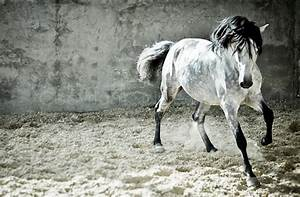

Style Image:


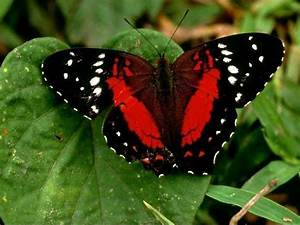

Stylized Image:


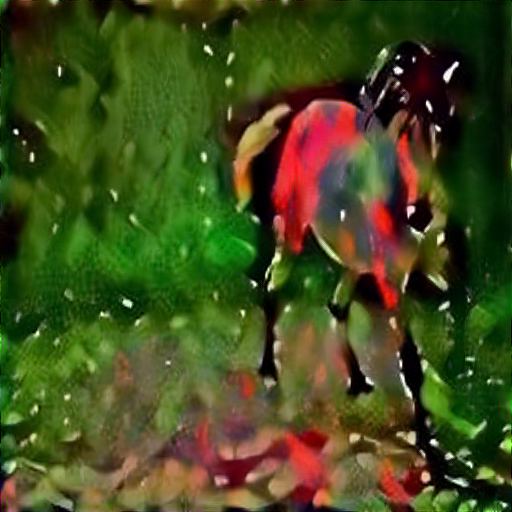


Styling cavallo:  25%|██▌       | 1/4 [00:14<00:43, 14.39s/image]


Generated image: cavallo8-gatto5.jpg
Content Image:


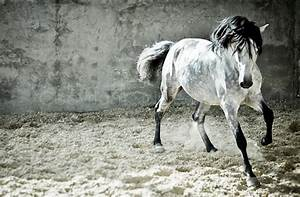

Style Image:


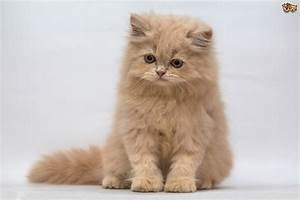

Stylized Image:


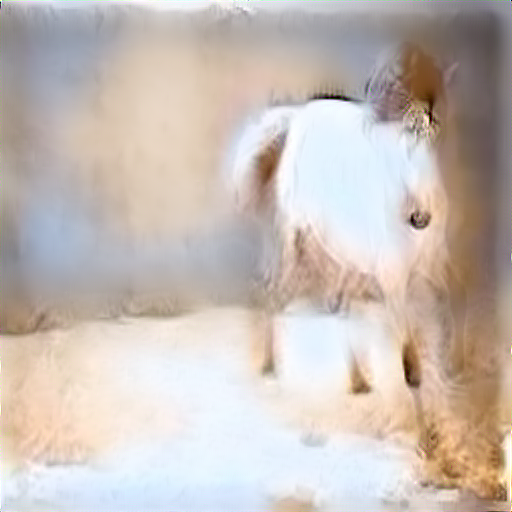


Styling cavallo:  50%|█████     | 2/4 [00:28<00:28, 14.39s/image]


Generated image: cavallo2-elefante5.jpg
Content Image:


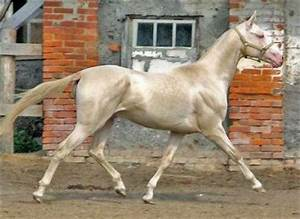

Style Image:


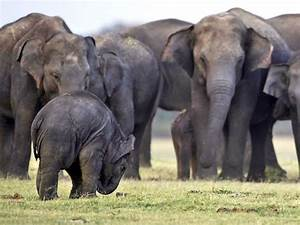

Stylized Image:


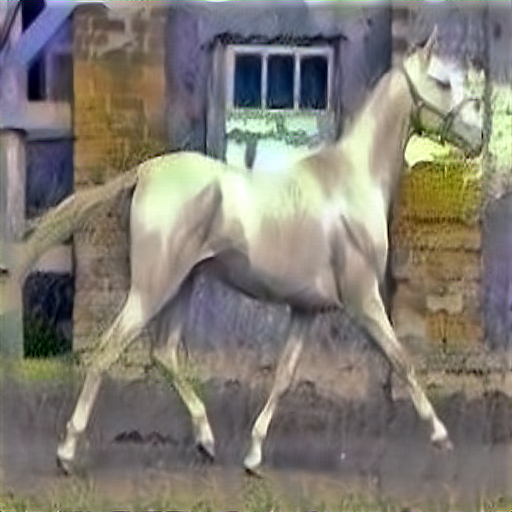


Styling cavallo: 100%|██████████| 4/4 [00:42<00:00, 10.57s/image]



Processing class: pecora



Styling pecora:   0%|          | 0/4 [00:00<?, ?image/s]


Generated image: pecora2-cane7.jpg
Content Image:


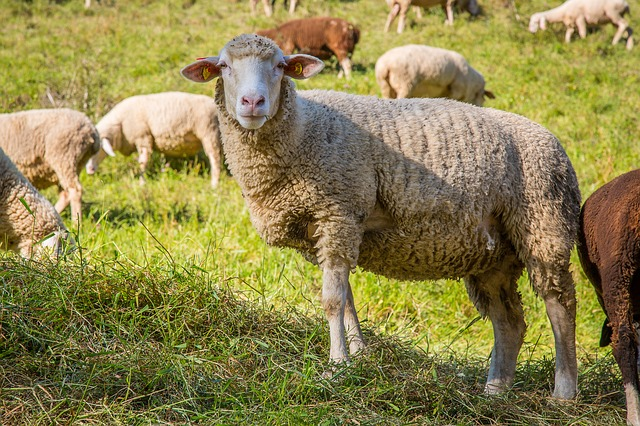

Style Image:


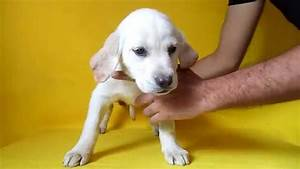

Stylized Image:


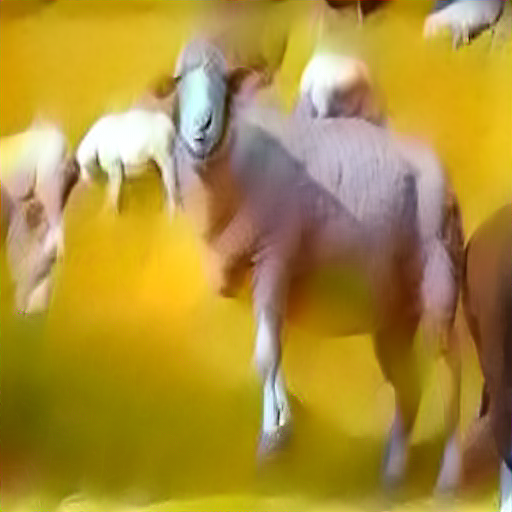


Styling pecora:  25%|██▌       | 1/4 [00:14<00:43, 14.41s/image]


Generated image: pecora2-cane1.jpg
Content Image:


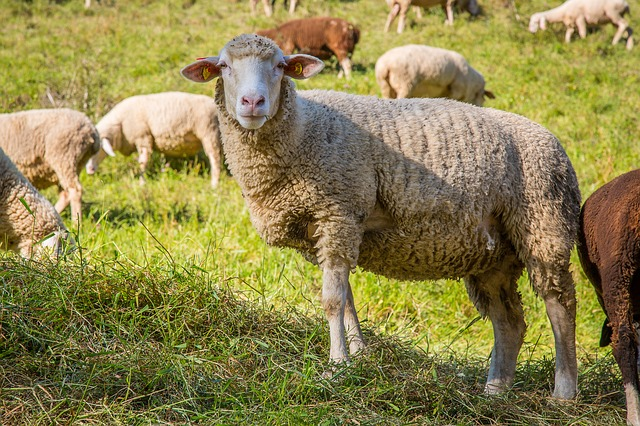

Style Image:


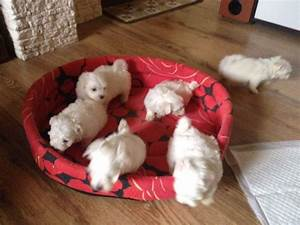

Stylized Image:


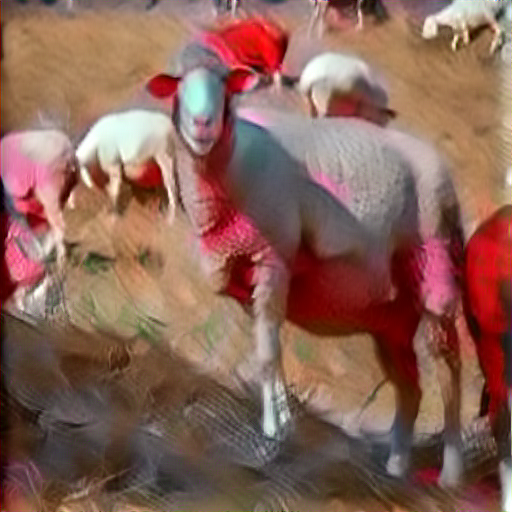


Styling pecora:  50%|█████     | 2/4 [00:28<00:28, 14.42s/image]


Generated image: pecora3-cane7.jpg
Content Image:


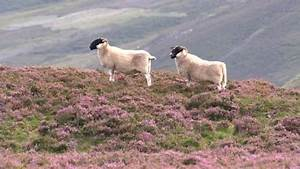

Style Image:


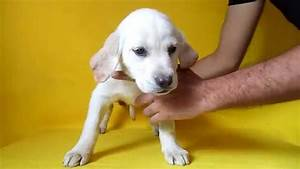

Stylized Image:


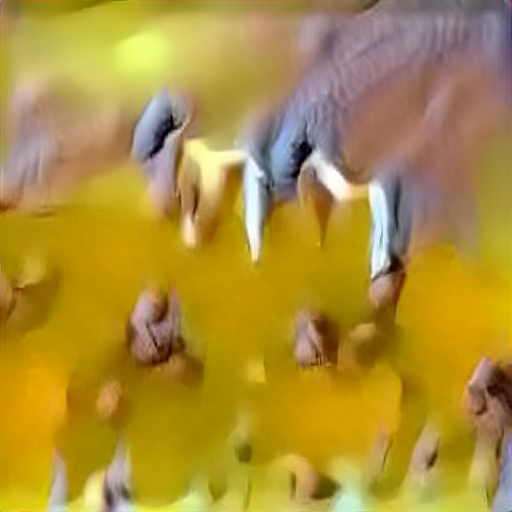


Styling pecora:  75%|███████▌  | 3/4 [00:43<00:14, 14.40s/image]


Generated image: pecora3-elefante4.jpg
Content Image:


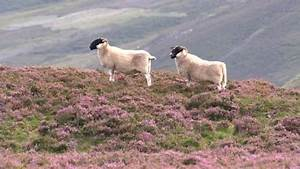

Style Image:


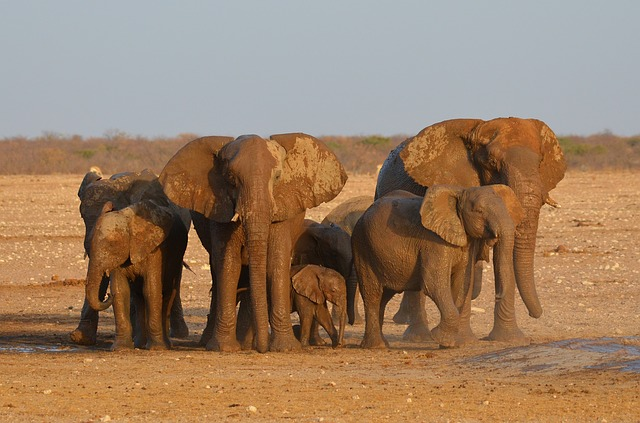

Stylized Image:


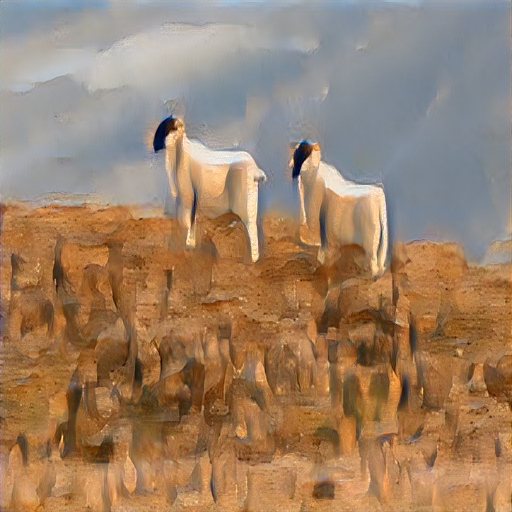


Styling pecora: 100%|██████████| 4/4 [00:56<00:00, 14.06s/image]



Processing class: elefante



Styling elefante:   0%|          | 0/4 [00:00<?, ?image/s]

KeyboardInterrupt: 

In [12]:
run_style_transfer_pipeline(test_mode=True)
# run_style_transfer_pipeline(test_mode=False, styles_per_image=5)